**Metodologia**

1. Seleção de variáveis: Visando à parcimonicidade do modelo, primeiro realizou-se uma seleção de variáveis com base nos seguintes critérios: (a) variáveis numéricas - coeficiente de variação e correlação de pearson (b) entropia normalizada e informação mútua normalizada. 

2. Amostragem estratificada: Para garantir eficiência computacional, foi extraída uma amostra estratificada do conjunto de dados. A estratificação utilizou a variável CO_MUNICIPIO_PROVA (código do município de aplicação da prova). 

3. Validação interna: A classe KPrototypeEvaluator foi usada para avaliar diferentes hiperparametros do algoritmo k-prototypes (número de clusters e gamma), usando como métricas TWSS, silhouette e índice de Dunn. Silhouette e Dunn foram calculados usando a matriz de distância calculada usando distância de Gower. 

4. Validação externa: Embora não haja true labels para uma validação externa clássica, buscou-se avaliar a capacidade de generalização. Cada algoritmo foi treinado com dados do Amazonas e seus rótulos comparados aos obtidos em um modelo treinado com dados do Rio de Janeiro, utilizando o Adjusted Rand Index (ARI) e inspeção visual.

5. Estabilidade e escalabilidade: A estabilidade foi medida por três experimentos, sempre com ARI:
(a) Seed – impacto da semente aleatória;
(b) Cross-sample – influência da amostra específica utilizada.
A escalabilidade foi avaliada pelo tempo de processamento em diferentes tamanhos de amostra.

6. Importância de variáveis e interpretabilidade: Treinou-se uma árvore de decisão tendo o cluster como variável resposta, a fim de identificar características-chave de cada grupo. Também se analisou a importância das variáveis originais via permutação em random forest e, por fim, a significância das diferenças entre clusters por ANOVA e qui-quadrado, complementada por medidas de efeito (Cohen’s d e Cramer’s V).

In [1]:
import sys
import os
import pandas as pd 

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from scripts.clustering.original_space_clustering import KPrototypesEvaluator, FeatureSelector

In [2]:
df = pd.read_csv(r'C:\Users\jaret\OneDrive\Documents\UFG\TCC\ENEM - final\data\MICRODADOS_RJ_clean_2023.csv')

**Seleção de variáveis**

--- FeatureSelector Initialized ---
Detected 6 numerical columns: ['CO_MUNICIPIO_PROVA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
Detected 29 categorical columns: ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025']
Performing stratified sampling on 'CO_MUNICIPIO_PROVA' with a 1.00% fraction...
Sampling complete. Active dataset reduced from 177828 to 1776 rows.

--- Starting Feature Analysis ---
Calculating Coefficient of Variation for numerical features...
Calculating Correlation Matrix for numerical features...
Calculating Normalized Entropy for categorical features...
Calculating Normalized Mutual Information for categorical features...


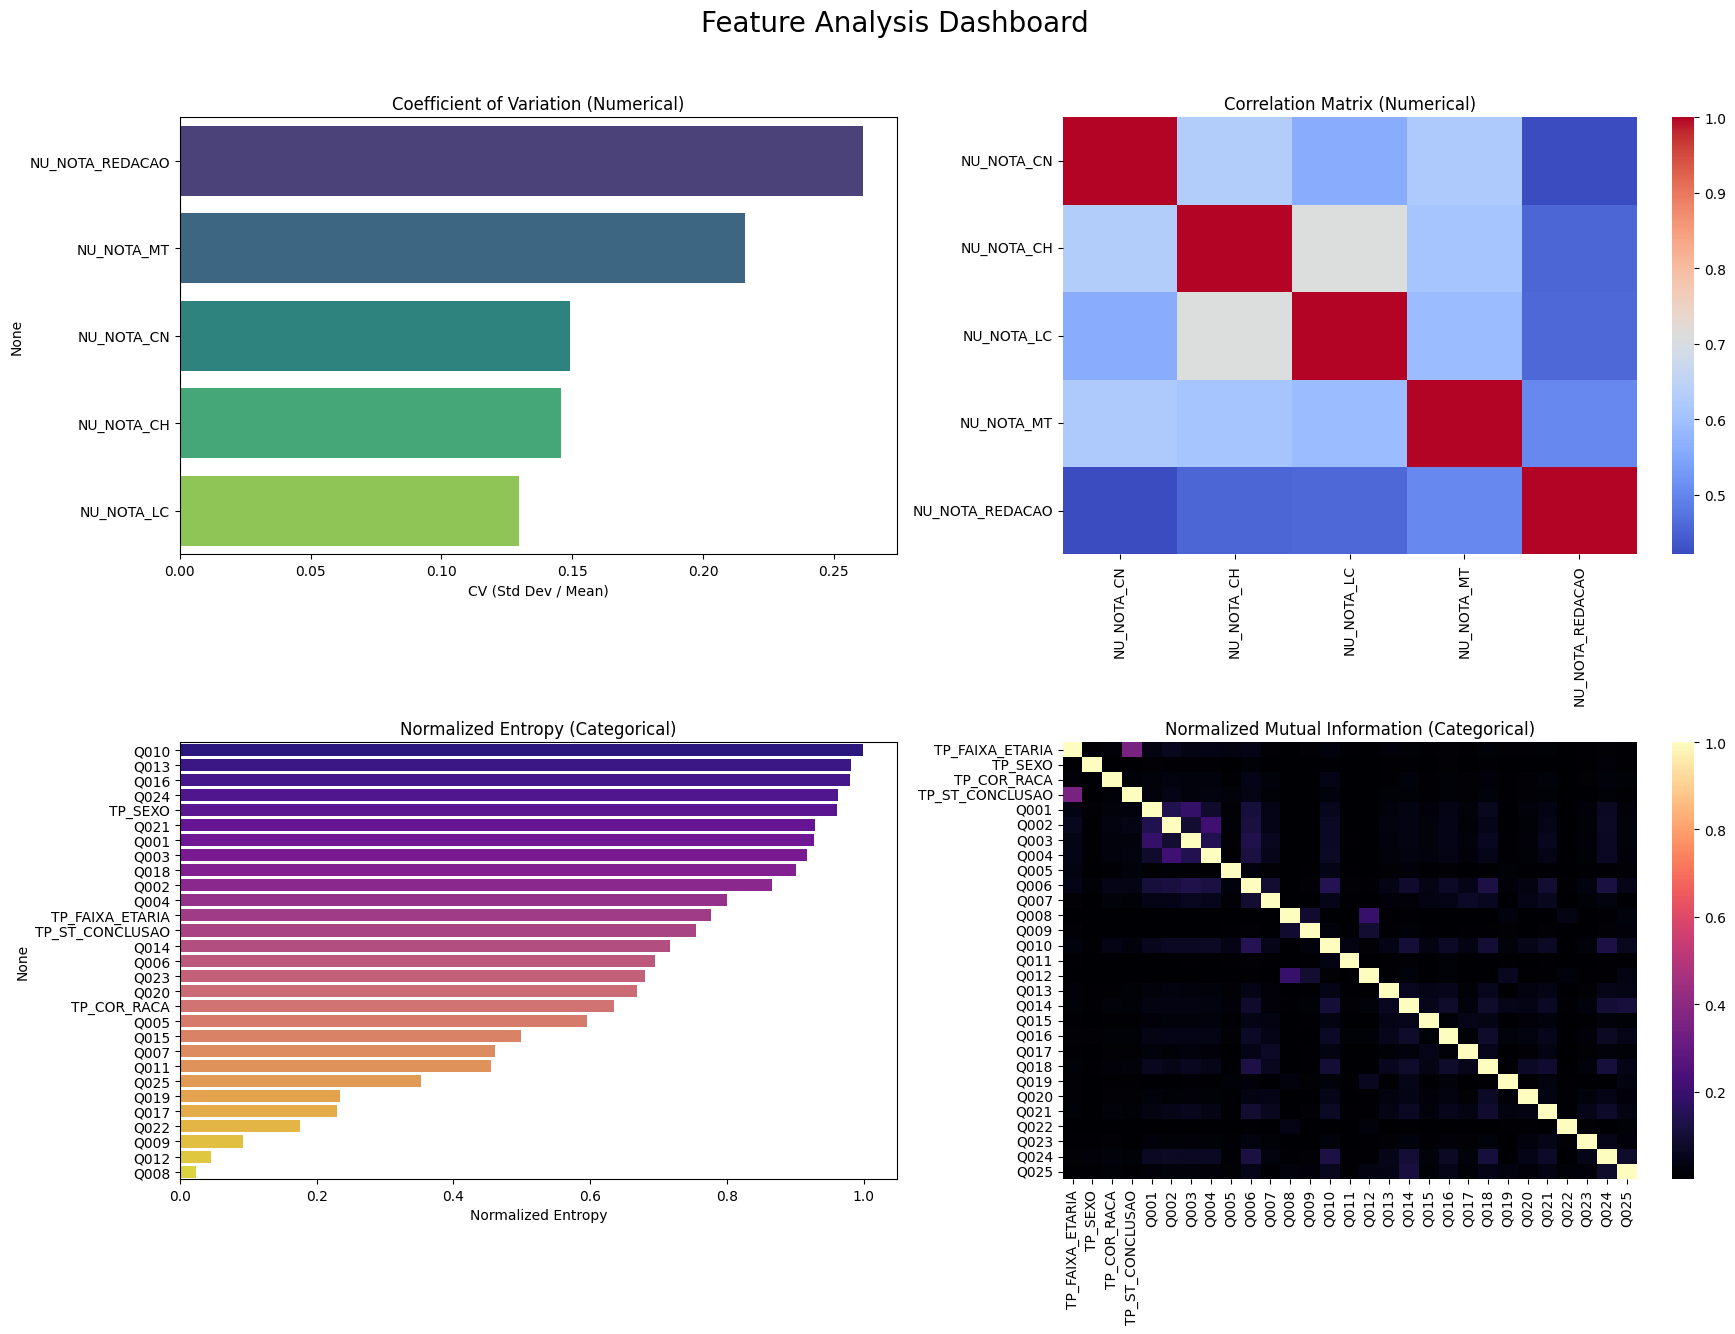

In [3]:
selector = FeatureSelector(df)
selector.stratified_sample(
    strata_col="CO_MUNICIPIO_PROVA", 
    sample_frac=0.01
)
selector.analyze_features()

In [4]:
df_selected = selector.select_features(
    cv_threshold=0.2, 
    correlation_threshold=0.7, 
    entropy_threshold=0.7, 
    mutual_info_threshold=0.5
)
selected_features = df_selected.columns.tolist()
selected_features.append('CO_MUNICIPIO_PROVA')


--- Starting Feature Selection Process ---

Analyzing 5 numerical features...
Checking for Coefficient of Variation below 0.2...
  -> Found 3 low-CV columns to drop: ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']
Checking for Pearson correlations above 0.7...
  -> No highly correlated column pairs found.

Checking for normalized entropy below 0.7...
  -> Found 15 low-entropy columns to drop: ['TP_COR_RACA', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q011', 'Q012', 'Q015', 'Q017', 'Q019', 'Q020', 'Q022', 'Q023', 'Q025']
Checking for normalized mutual information above 0.5...
  -> No high mutual information column pairs found.

Dropping a total of 18 unique columns: ['Q008', 'Q011', 'NU_NOTA_CH', 'Q012', 'Q017', 'Q006', 'NU_NOTA_CN', 'Q005', 'Q009', 'Q015', 'TP_COR_RACA', 'Q019', 'Q022', 'Q025', 'Q023', 'Q020', 'Q007', 'NU_NOTA_LC']
Feature selection complete.

--- Feature Selection Finished ---


**Iniciação da instância da classe do avaliador dos modelos**

In [5]:
k_range = range(2,9)
evaluator = KPrototypesEvaluator(
    df=df[selected_features], 
    original_df_full=df,
    k_range=k_range, 
    gamma_list=[0.1, 0.5, 0.8, 1.0, 2.0, 4.0],
    random_state=42
)
evaluator.stratified_sample(
    strata_col="CO_MUNICIPIO_PROVA", 
    sample_frac=0.01
)
evaluator.scale_numerical_features()

Full original dataframe loaded for statistical analysis.
Detected 3 numerical columns: ['NU_NOTA_MT', 'NU_NOTA_REDACAO', 'CO_MUNICIPIO_PROVA']
Detected 14 categorical columns: ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ST_CONCLUSAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q010', 'Q013', 'Q014', 'Q016', 'Q018', 'Q021', 'Q024']
Performing stratified sampling on 'CO_MUNICIPIO_PROVA' with a 1.00% fraction...
Sampling complete. Active dataset reduced from 177828 to 1776 rows.
Scaling 2 numerical features...
Scaling complete. Active dataset has been updated.


,TP_FAIXA_ETARIA,TP_SEXO,TP_ST_CONCLUSAO,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q010,Q013,Q014,Q016,Q018,Q021,Q024
49534,17 anos,Masculino,Estou cursando e concluirei o Ensino Médio em ...,1.792239,0.811575,Faculdade ou pós,EM completo,"Grupo 4: técnicos, supervisores, pequenos empr...",Não sabe,Sim,Sim,Sim,Sim,Não,Não,Sim
36740,17 anos,Feminino,Estou cursando e concluirei o Ensino Médio apó...,-0.530709,0.811575,EM completo,Faculdade ou pós,Grupo 3: operários / técnicos manuais,"Grupo 4: técnicos, supervisores, pequenos empr...",Sim,Sim,Sim,Não,Não,Não,Sim
109614,18 anos,Masculino,Estou cursando e concluirei o Ensino Médio em ...,1.488379,0.115491,EM completo,EM completo,Grupo 5: profissões de nível superior / gestores,Não sabe,Sim,Sim,Sim,Não,Sim,Sim,Sim
40550,18 anos,Feminino,Estou cursando e concluirei o Ensino Médio em ...,-1.758601,1.043603,EF incompleto,EF incompleto,Grupo 1: ocupações rurais / básicos,Grupo 1: ocupações rurais / básicos,Não,Não,Sim,Não,Não,Não,Não
8599,19 anos,Feminino,Já concluí o Ensino Médio,-0.658563,-0.928634,Faculdade ou pós,Faculdade ou pós,Não sabe,"Grupo 4: técnicos, supervisores, pequenos empr...",Não,Não,Não,Não,Não,Não,Sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12413,18 anos,Feminino,Estou cursando e concluirei o Ensino Médio em ...,0.536950,-1.392690,EM completo,EM completo,"Grupo 2: serviços básicos, comércio","Grupo 2: serviços básicos, comércio",Não,Sim,Sim,Sim,Não,Não,Não
109663,18 anos,Feminino,Já concluí o Ensino Médio,0.458079,0.231505,EF incompleto,Faculdade ou pós,Grupo 3: operários / técnicos manuais,"Grupo 4: técnicos, supervisores, pequenos empr...",Não,Sim,Sim,Sim,Não,Não,Não
155122,17 anos,Masculino,Estou cursando e concluirei o Ensino Médio em ...,1.794730,1.043603,Faculdade ou pós,Faculdade ou pós,Grupo 5: profissões de nível superior / gestores,Grupo 5: profissões de nível superior / gestores,Sim,Não,Sim,Sim,Não,Não,Sim
120857,18 anos,Feminino,Estou cursando e concluirei o Ensino Médio em ...,0.711296,0.347519,EF incompleto,EM completo,Grupo 3: operários / técnicos manuais,"Grupo 4: técnicos, supervisores, pequenos empr...",Sim,Sim,Sim,Sim,Sim,Sim,Não



Running K-Prototypes for k in [2, 3, 4, 5, 6, 7, 8] and gamma in [0.1, 0.5, 0.8, 1.0, 2.0, 4.0]...
Calculating Gower distance matrix for evaluation metrics...
Gower matrix calculation complete.
  - Testing k=2, gamma=0.10...
  - Testing k=3, gamma=0.10...
  - Testing k=4, gamma=0.10...
  - Testing k=5, gamma=0.10...
  - Testing k=6, gamma=0.10...
  - Testing k=7, gamma=0.10...
  - Testing k=8, gamma=0.10...
  - Testing k=2, gamma=0.50...
  - Testing k=3, gamma=0.50...
  - Testing k=4, gamma=0.50...
  - Testing k=5, gamma=0.50...
  - Testing k=6, gamma=0.50...
  - Testing k=7, gamma=0.50...
  - Testing k=8, gamma=0.50...
  - Testing k=2, gamma=0.80...
  - Testing k=3, gamma=0.80...
  - Testing k=4, gamma=0.80...
  - Testing k=5, gamma=0.80...
  - Testing k=6, gamma=0.80...
  - Testing k=7, gamma=0.80...
  - Testing k=8, gamma=0.80...
  - Testing k=2, gamma=1.00...
  - Testing k=3, gamma=1.00...
  - Testing k=4, gamma=1.00...
  - Testing k=5, gamma=1.00...
  - Testing k=6, gamma=1.00...

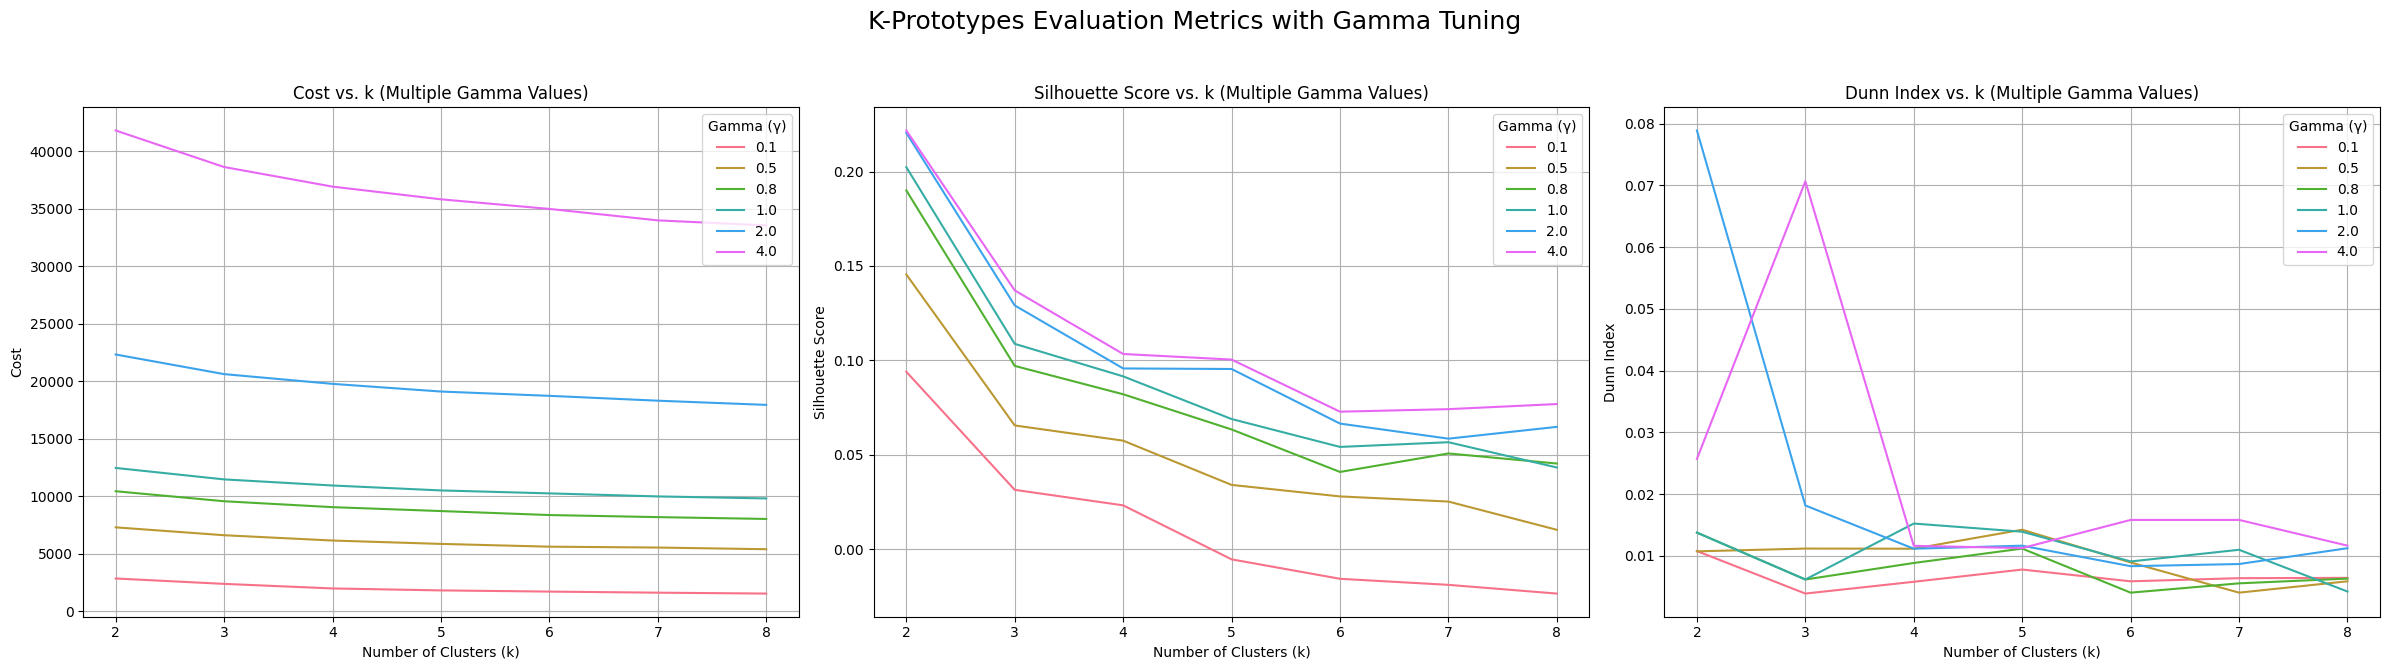

In [6]:
evaluator.run_and_evaluate()
evaluator.plot_evaluation_metrics()

In [7]:
k_prot_model = evaluator.run_final_model(optimal_k=2, optimal_gamma=2)
k_prot_model


Running final K-Prototypes model with k=2, gamma=2...
Final Gamma used: 2
Final model is trained and cluster labels are added to the DataFrame.


,TP_FAIXA_ETARIA,TP_SEXO,TP_ST_CONCLUSAO,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q010,Q013,Q014,Q016,Q018,Q021,Q024,cluster_kproto
49534,17 anos,Masculino,Estou cursando e concluirei o Ensino Médio em ...,1.792239,0.811575,Faculdade ou pós,EM completo,"Grupo 4: técnicos, supervisores, pequenos empr...",Não sabe,Sim,Sim,Sim,Sim,Não,Não,Sim,0
36740,17 anos,Feminino,Estou cursando e concluirei o Ensino Médio apó...,-0.530709,0.811575,EM completo,Faculdade ou pós,Grupo 3: operários / técnicos manuais,"Grupo 4: técnicos, supervisores, pequenos empr...",Sim,Sim,Sim,Não,Não,Não,Sim,0
109614,18 anos,Masculino,Estou cursando e concluirei o Ensino Médio em ...,1.488379,0.115491,EM completo,EM completo,Grupo 5: profissões de nível superior / gestores,Não sabe,Sim,Sim,Sim,Não,Sim,Sim,Sim,0
40550,18 anos,Feminino,Estou cursando e concluirei o Ensino Médio em ...,-1.758601,1.043603,EF incompleto,EF incompleto,Grupo 1: ocupações rurais / básicos,Grupo 1: ocupações rurais / básicos,Não,Não,Sim,Não,Não,Não,Não,1
8599,19 anos,Feminino,Já concluí o Ensino Médio,-0.658563,-0.928634,Faculdade ou pós,Faculdade ou pós,Não sabe,"Grupo 4: técnicos, supervisores, pequenos empr...",Não,Não,Não,Não,Não,Não,Sim,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12413,18 anos,Feminino,Estou cursando e concluirei o Ensino Médio em ...,0.536950,-1.392690,EM completo,EM completo,"Grupo 2: serviços básicos, comércio","Grupo 2: serviços básicos, comércio",Não,Sim,Sim,Sim,Não,Não,Não,1
109663,18 anos,Feminino,Já concluí o Ensino Médio,0.458079,0.231505,EF incompleto,Faculdade ou pós,Grupo 3: operários / técnicos manuais,"Grupo 4: técnicos, supervisores, pequenos empr...",Não,Sim,Sim,Sim,Não,Não,Não,1
155122,17 anos,Masculino,Estou cursando e concluirei o Ensino Médio em ...,1.794730,1.043603,Faculdade ou pós,Faculdade ou pós,Grupo 5: profissões de nível superior / gestores,Grupo 5: profissões de nível superior / gestores,Sim,Não,Sim,Sim,Não,Não,Sim,0
120857,18 anos,Feminino,Estou cursando e concluirei o Ensino Médio em ...,0.711296,0.347519,EF incompleto,EM completo,Grupo 3: operários / técnicos manuais,"Grupo 4: técnicos, supervisores, pequenos empr...",Sim,Sim,Sim,Sim,Sim,Sim,Não,0



--- Generating Cluster Size Plot ---


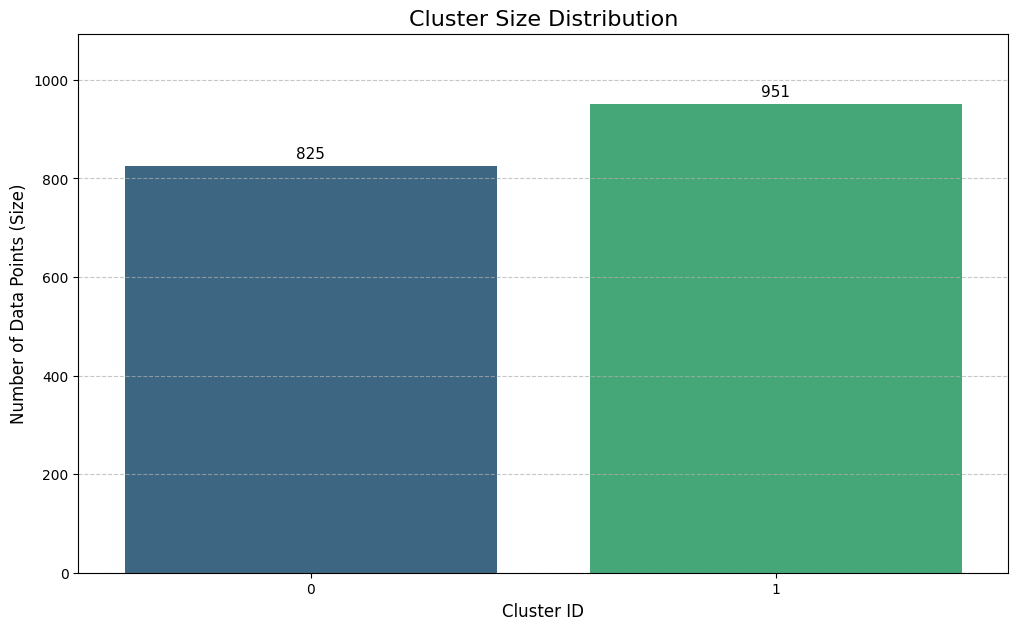

In [8]:
evaluator.plot_cluster_sizes()


--- Generating 2D Cluster Plot using FAMD on all features ---
Using the pre-scaled dataframe for FAMD.
FAMD components generated. Plotting now...


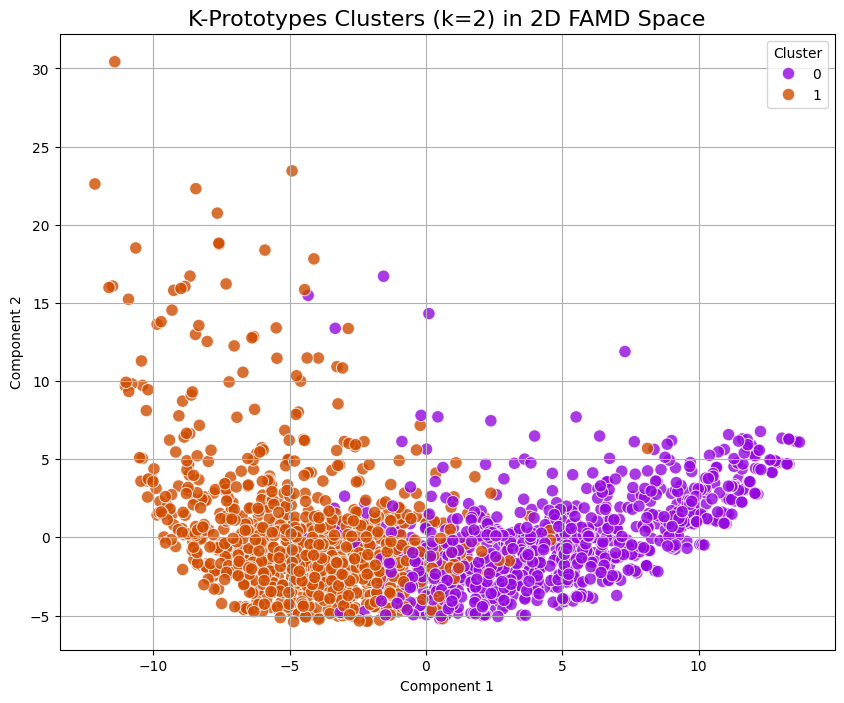

In [9]:
evaluator.plot_clusters_2d()

**Avaliação de validade externa**

In [10]:
df_am = pd.read_csv(r'C:\Users\jaret\OneDrive\Documents\UFG\TCC\ENEM - final\data\MICRODADOS_AM_clean_2023.csv')
df_am = df_am.loc[:, selected_features]

In [11]:
k_range = range(2,9)
evaluator_am = KPrototypesEvaluator(
    df=df_am, 
    k_range=k_range, 
    random_state=42
)
evaluator_am.stratified_sample(
    strata_col="CO_MUNICIPIO_PROVA", 
    sample_frac=0.05
)
evaluator_am.scale_numerical_features()
evaluator_am.run_final_model(optimal_k=2, optimal_gamma=2)

Assuming input dataframe contains all features for statistical analysis.
Detected 3 numerical columns: ['NU_NOTA_MT', 'NU_NOTA_REDACAO', 'CO_MUNICIPIO_PROVA']
Detected 14 categorical columns: ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ST_CONCLUSAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q010', 'Q013', 'Q014', 'Q016', 'Q018', 'Q021', 'Q024']
Performing stratified sampling on 'CO_MUNICIPIO_PROVA' with a 5.00% fraction...
Sampling complete. Active dataset reduced from 44720 to 2237 rows.
Scaling 2 numerical features...
Scaling complete. Active dataset has been updated.

Running final K-Prototypes model with k=2, gamma=2...
Final Gamma used: 2
Final model is trained and cluster labels are added to the DataFrame.


,TP_FAIXA_ETARIA,TP_SEXO,TP_ST_CONCLUSAO,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q010,Q013,Q014,Q016,Q018,Q021,Q024,cluster_kproto
27004,17 anos,Feminino,Estou cursando e concluirei o Ensino Médio em ...,-1.233048,-0.419925,EF completo,EM completo,Grupo 1: ocupações rurais / básicos,Grupo 1: ocupações rurais / básicos,Não,Não,Não,Não,Não,Não,Não,0
12953,22 anos,Masculino,Já concluí o Ensino Médio,-0.181983,1.423429,EF incompleto,EF incompleto,Grupo 1: ocupações rurais / básicos,Grupo 1: ocupações rurais / básicos,Não,Não,Sim,Não,Não,Não,Não,0
28689,18 anos,Feminino,Estou cursando e concluirei o Ensino Médio em ...,0.276335,0.071636,EF completo,EF completo,Grupo 1: ocupações rurais / básicos,Grupo 1: ocupações rurais / básicos,Não,Não,Não,Não,Não,Não,Não,0
36259,17 anos,Masculino,Estou cursando e concluirei o Ensino Médio em ...,0.430612,-0.419925,Faculdade ou pós,EM completo,"Grupo 4: técnicos, supervisores, pequenos empr...","Grupo 4: técnicos, supervisores, pequenos empr...",Não,Sim,Sim,Sim,Não,Sim,Sim,1
21852,17 anos,Feminino,Estou cursando e concluirei o Ensino Médio em ...,-0.836079,-1.894609,EF incompleto,EF incompleto,Grupo 1: ocupações rurais / básicos,Grupo 1: ocupações rurais / básicos,Não,Não,Sim,Não,Não,Sim,Não,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30642,17 anos,Masculino,Estou cursando e concluirei o Ensino Médio em ...,0.290771,-1.034377,EM completo,EM completo,Grupo 3: operários / técnicos manuais,"Grupo 2: serviços básicos, comércio",Não,Sim,Sim,Não,Não,Não,Não,0
21507,18 anos,Feminino,Estou cursando e concluirei o Ensino Médio em ...,-0.041240,-0.788596,EF incompleto,EF incompleto,Grupo 1: ocupações rurais / básicos,"Grupo 2: serviços básicos, comércio",Não,Não,Não,Não,Não,Não,Não,0
43086,17 anos,Feminino,Já concluí o Ensino Médio,-0.412947,0.071636,EF completo,Faculdade ou pós,Grupo 1: ocupações rurais / básicos,"Grupo 4: técnicos, supervisores, pequenos empr...",Não,Não,Sim,Não,Não,Não,Não,0
8854,17 anos,Masculino,Estou cursando e concluirei o Ensino Médio em ...,-0.947952,0.071636,Faculdade ou pós,Faculdade ou pós,"Grupo 4: técnicos, supervisores, pequenos empr...","Grupo 4: técnicos, supervisores, pequenos empr...",Não,Não,Sim,Não,Não,Não,Não,1


In [12]:
evaluator.cross_predict_and_evaluate_kproto(
    target_evaluator=evaluator_am, 
    name_source="RJ", 
    name_target="AM"
)


--- Cross-Model Evaluation: 'RJ' Model -> 'AM' Data ---
Predicting labels on 'AM' data using 'RJ' model...
✅ Adjusted Rand Score (ARI): 0.7021


0.702108561699766


--- Visualizing Cross-Prediction: 'RJ' Model vs. 'AM' Clusters ---
Using the target's pre-scaled data for FAMD visualization.
Reducing target data to 2D using FAMD...


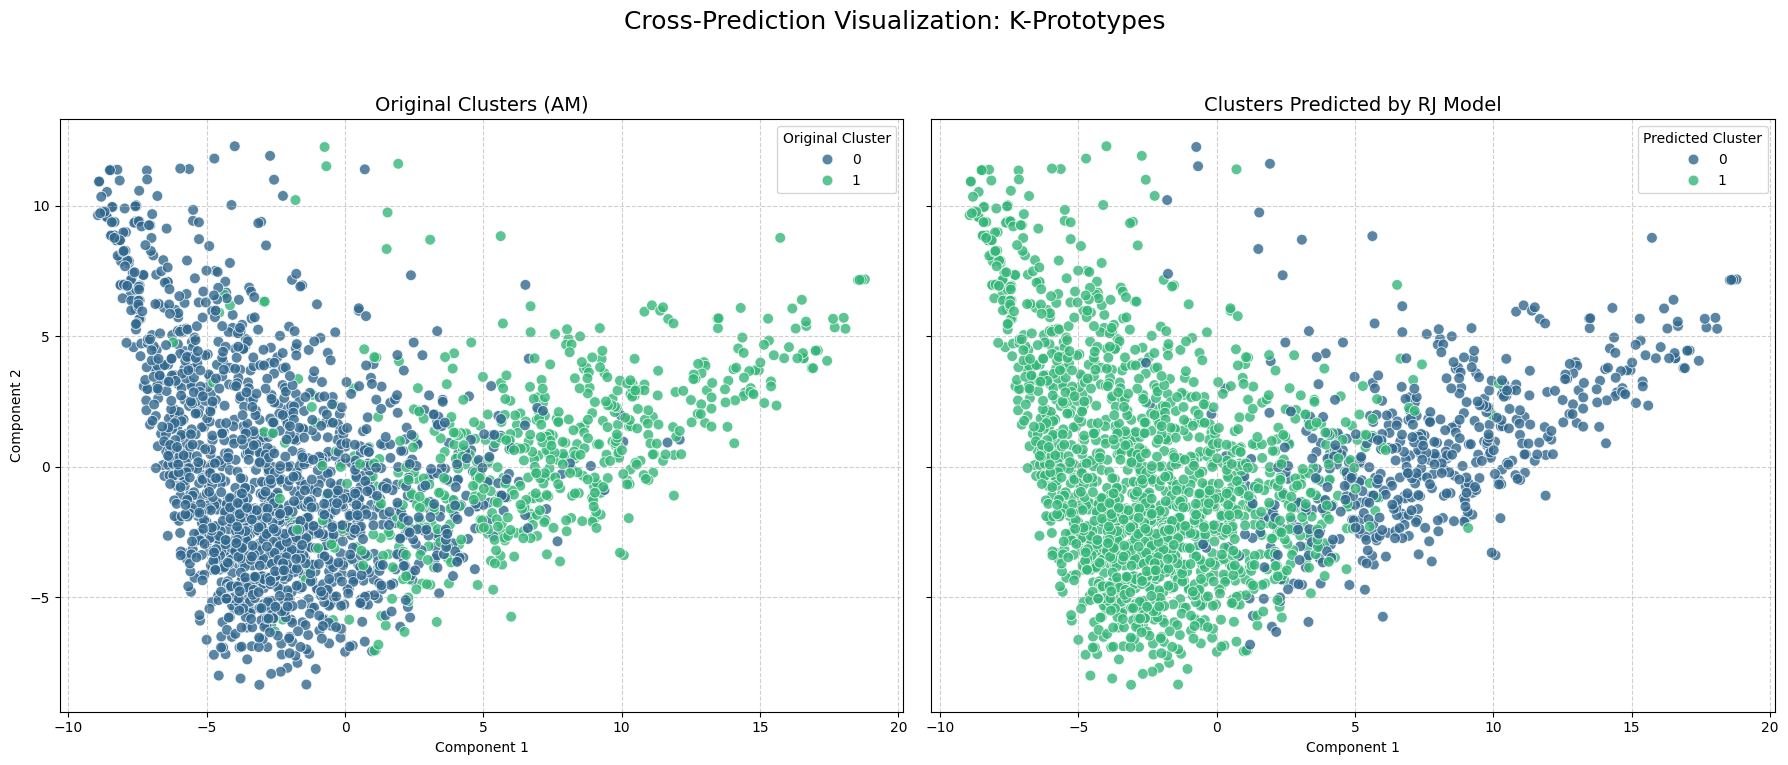

In [13]:
evaluator.plot_cross_prediction_comparison(
    target_evaluator=evaluator_am, 
    name_source="RJ", 
    name_target="AM"
)

**Avaliação de estabilidade e escalabilidade**


--- Evaluating Cross-Sample Stability (50 iterations) ---
Calculating baseline clustering on the current active sample...
Using existing final model as baseline.
Beginning 50 cross-sample validation iterations...
  Iteration 10/50...
  Iteration 20/50...
  Iteration 30/50...
  Iteration 40/50...
  Iteration 50/50...

Cross-sample stability evaluation complete.
K-Prototypes (k=2) Stability: Mean ARI = 0.7907, Std Dev = 0.0658


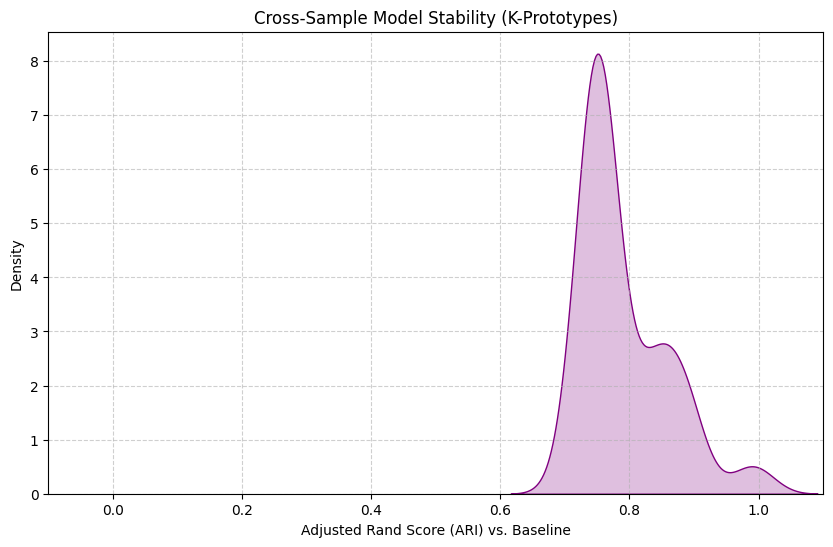

[1.0,
 0.7342444520380382,
 0.7517287607983697,
 0.7439371022969861,
 0.7419932681942806,
 0.7458827692118529,
 0.7517343071764612,
 0.8176103975625553,
 0.7419932681942806,
 0.8526250981862289,
 0.7439371022969861,
 0.7536839142533307,
 0.8904905580967388,
 0.7654737376686579,
 0.7381152805374542,
 0.8904903144519299,
 0.8196497507262641,
 0.8756699695160052,
 0.7674473199881845,
 0.7439364163051746,
 0.8526242282969566,
 0.7576040072296065,
 0.7654737376686579,
 0.7674473199881845,
 0.7074673044288704,
 0.7361782593038112,
 0.7576040072296065,
 0.8904900658336604,
 0.844317717952155,
 0.7993787796009733,
 0.7595674816818208,
 0.7419932681942806,
 0.9820526799042282,
 0.8401806849663439,
 0.7419946505874246,
 0.7458820942027026,
 0.7635020193839955,
 0.7419925594191698,
 0.7400540544102374,
 0.7576040072296065,
 0.7342467146269693,
 0.873562416409939,
 0.7595674816818208,
 0.7536846468435066,
 0.8926184500747543,
 0.765473082746239,
 0.7419939652503023,
 0.844317717952155,
 0.84018068

In [14]:
evaluator.evaluate_cross_sample_stability(
    strata_col="CO_MUNICIPIO_PROVA", 
    sample_frac=0.01, 
    optimal_k=2, 
    optimal_gamma=2)

In [15]:
seeds = [0, 51, 123, 2025, 9999]
evaluator.evaluate_stability_by_seed(
    optimal_k=2, 
    optimal_gamma=2, 
    random_seeds=seeds
)


--- Evaluating Stability by Seed for k=2 ---
K-Prototypes (k=2) Mean ARI vs. baseline seed: 1.0000 (Indicates sensitivity to initialization)


np.float64(1.0)


--- Evaluating Processing Time for k=2 ---
Timing for n=177 samples...
Timing for n=354 samples...
Timing for n=532 samples...
Timing for n=710 samples...
Timing for n=887 samples...
Timing for n=1065 samples...
Timing for n=1243 samples...
Timing for n=1420 samples...
Timing for n=1598 samples...
Timing for n=1776 samples...


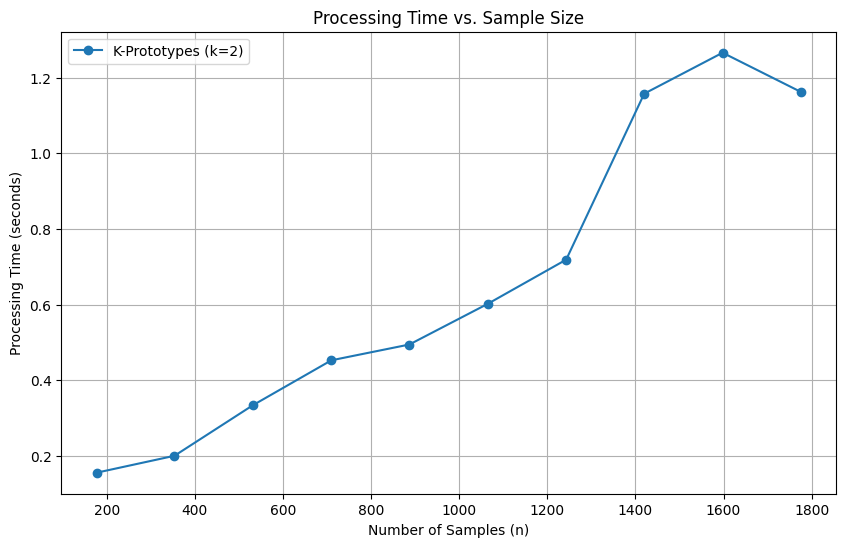

,Number of Samples,Processing Time (s)
0,177,0.155261
1,354,0.200072
2,532,0.333843
3,710,0.452563
4,887,0.494318
5,1065,0.601961
6,1243,0.718783
7,1420,1.157649
8,1598,1.266026
9,1776,1.162107


In [16]:
evaluator.evaluate_processing_time(optimal_k=2, optimal_gamma=2)

**Importância de variáveis e interpretabilidade**


--- Generating Decision Tree Visualization (max_depth=3) 🌳 ---
Found categorical features: ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ST_CONCLUSAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q010', 'Q013', 'Q014', 'Q016', 'Q018', 'Q021', 'Q024']. Applying One-Hot Encoding for the tree...


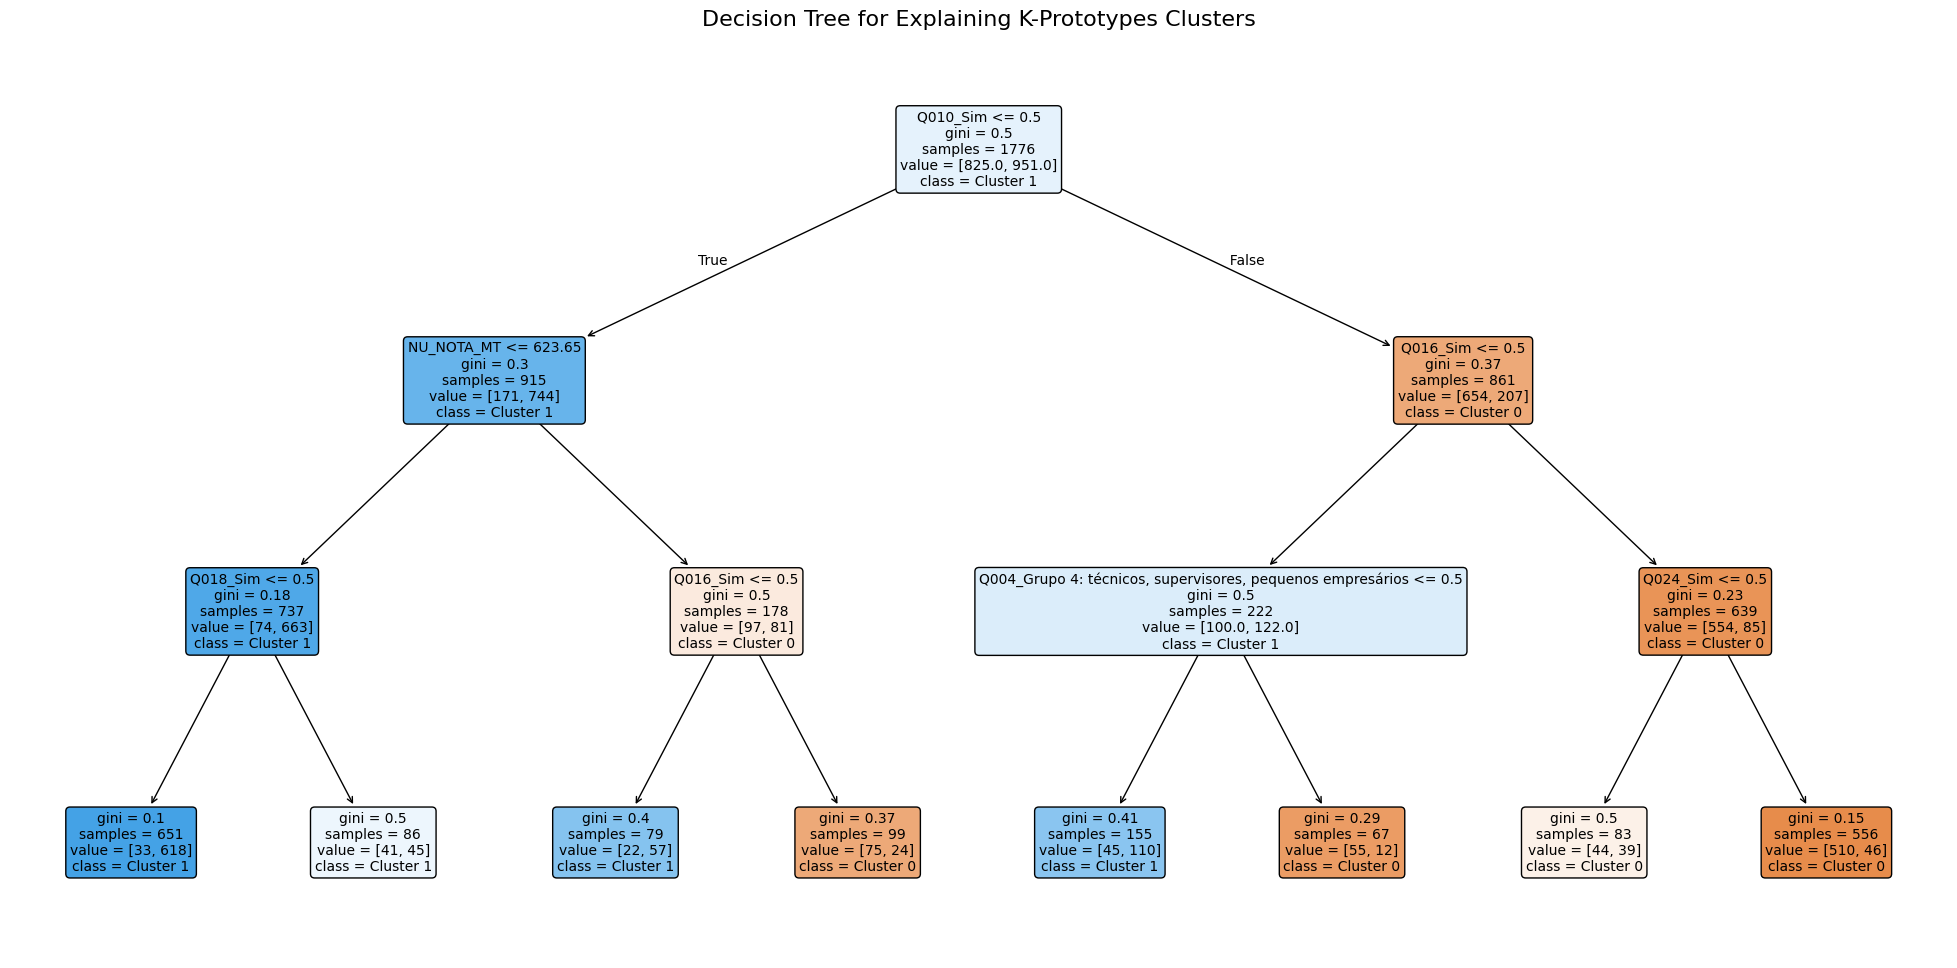

In [17]:
evaluator.plot_decision_tree_importance()


--- Calculating Permutation Importance for K-Prototypes ---
Training Random Forest surrogate model...
Calculating importance based on 'accuracy' drop...


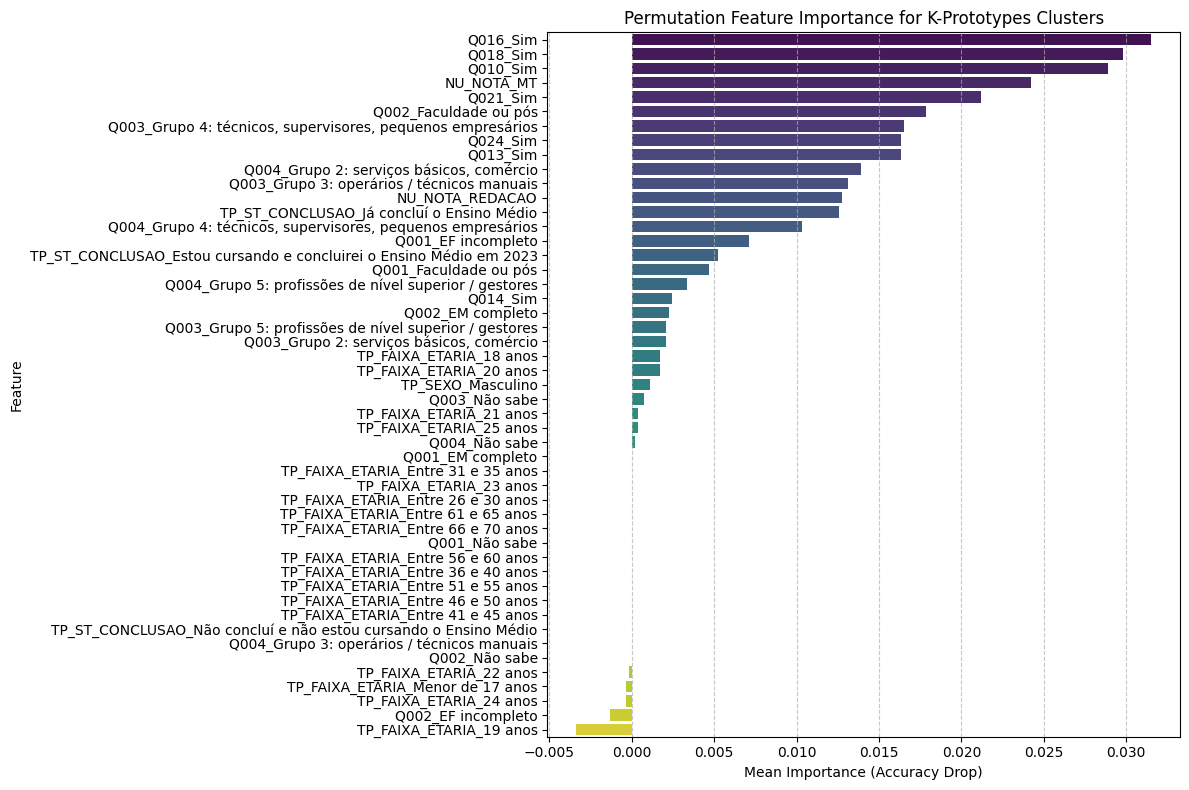

,feature,importance_mean,importance_std
45,Q016_Sim,3.151970e-02,0.005678
46,Q018_Sim,2.983114e-02,0.006018
42,Q010_Sim,2.889306e-02,0.008808
0,NU_NOTA_MT,2.420263e-02,0.007336
47,Q021_Sim,2.120075e-02,0.006870
30,Q002_Faculdade ou pós,1.782364e-02,0.004538
34,"Q003_Grupo 4: técnicos, supervisores, pequenos...",1.651032e-02,0.005226
48,Q024_Sim,1.632270e-02,0.006502
43,Q013_Sim,1.632270e-02,0.002789
37,"Q004_Grupo 2: serviços básicos, comércio",1.388368e-02,0.003580


In [18]:
evaluator.plot_permutation_importance()

In [19]:
anova_results, chi2_results = evaluator.calculate_cluster_statistics()


--- Calculating Cluster Statistics for K-Prototypes ---
Statistical analysis complete.


In [20]:
anova_results

,F-statistic,P-value,Significant
Variable,,,
CO_MUNICIPIO_PROVA,4.334611,3.748799e-02,True
NU_NOTA_CN,332.022446,3.867522e-68,True
NU_NOTA_CH,266.407057,6.620863e-56,True
NU_NOTA_LC,232.337712,2.153642e-49,True
NU_NOTA_MT,630.835175,2.325325e-119,True
NU_NOTA_REDACAO,399.196778,2.879224e-80,True


In [21]:
chi2_results

,Chi-Square,P-value,Significant
Variable,,,
TP_FAIXA_ETARIA,228.507967,1.856950e-38,True
TP_SEXO,20.439230,6.155498e-06,True
TP_COR_RACA,134.868028,2.203364e-27,True
TP_ST_CONCLUSAO,161.128521,1.046124e-34,True
Q001,480.694198,1.002820e-102,True
Q002,529.739832,2.472442e-113,True
Q003,578.036066,1.124777e-122,True
Q004,580.314854,3.620663e-123,True
Q005,43.359388,8.714968e-09,True


In [22]:
cohens_d_results, cramers_v_results = evaluator.calculate_effect_sizes()


--- Calculating Effect Sizes for K-Prototypes ---
Effect size calculation complete.


In [23]:
cohens_d_results

,,Cohen's d
Variable,Comparison,
CO_MUNICIPIO_PROVA,Cluster 0.0 vs 1.0,0.099056
NU_NOTA_CN,Cluster 0.0 vs 1.0,0.866938
NU_NOTA_CH,Cluster 0.0 vs 1.0,0.776564
NU_NOTA_LC,Cluster 0.0 vs 1.0,0.725211
NU_NOTA_MT,Cluster 0.0 vs 1.0,1.194984
NU_NOTA_REDACAO,Cluster 0.0 vs 1.0,0.950600


In [24]:
cramers_v_results

,Cramér's V
Variable,
TP_FAIXA_ETARIA,0.358698
TP_SEXO,0.107278
TP_COR_RACA,0.275571
TP_ST_CONCLUSAO,0.301207
Q001,0.520251
Q002,0.546147
Q003,0.570500
Q004,0.571624
Q005,0.156250
